### Colab Stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/ThesisFinal")

### Training Cell

In [1]:
#-- Define Dataset and Dataloader to train on--#
import jax
from models.disrnn_utils import create_disrnn_train_state, disrnn_trainstep
from models.gru_utils import create_gru_train_state, gru_trainstep, gru_value_trainstep
from models.rnn_utils import train_model, load_model_state
from torch.utils.data import DataLoader
from custom_datasets import MoreThen3Dataset, custom_collate, from_disk, to_disk

import absl.logging
absl.logging.set_verbosity('error')

# dataset = MyStarkweather(n_sequences=500, len_sequences=1_000, omission_probability=0.0, iti_p=1/8, iti_min=10)
# train_dataloader = DataLoader(dataset,
#                               batch_size=10,
#                               drop_last=True,
#                               collate_fn=custom_collate)

# train_dataloader = DataLoader(from_disk("RLDataset", "data/leakyactor2"),
#                               batch_size=4,
#                               drop_last=True,
#                               collate_fn=custom_collate)


# -- Creating training state, using a random key --#
# master_key = jax.random.PRNGKey(0)
# state = create_disrnn_train_state(master_rng_key=master_key,
#                                   learning_rate=0.001,
#                                   hidden_size=5,
#                                   batch_size=10,
#                                   seq_length=1000,
#                                   in_dim=2,
#                                   out_dim=2,
#                                   update_mlp_shape=[5, 5, 5],
#                                   choice_mlp_shape=[2, 2],
#                                   kl_loss_factor=0.
#                                   )

# trained_model_state, training_metrics = train_model(state,
#                                                     train_dataloader,
#                                                     train_step_fun=disrnn_trainstep,
#                                                     num_epochs=100,
#                                                     print_every_other=1,)

# master_key = jax.random.PRNGKey(0)
# state = create_gru_train_state(master_key,
#                                learning_rate=0.001,
#                                hidden_size=10,
#                                batch_size=10,
#                                seq_length=1_000,
#                                out_dim=1,
#                                in_dim=2)
# trained_model_state, training_metrics = train_model(state,
#                                                     train_dataloader,
#                                                     train_step_fun=gru_value_trainstep,
#                                                     num_epochs=150,
#                                                     print_every_other=1)
# del master_key

### Evaluation/ Inspection

#### Eval

In [ ]:
from models.rnn_utils import eval

outputs, weights = eval(MoreThen3Dataset(),
                        trained_model_state,
                        true_output=2,
                        dataset_end=3,
                        inspect=True)
outputs, weights 

#### DisRNN

In [ ]:
from models.disrnn_analysis import plot_bottlenecks, plot_bottleneck_evolution, plot_update_rules
from models.rnn_utils import load_model_state

# master_key = jax.random.PRNGKey(0)
# state = create_disrnn_train_state(master_rng_key=master_key,
#                                   learning_rate=0.001,
#                                   hidden_size=5,
#                                   batch_size=4,
#                                   seq_length=1000,
#                                   in_dim=2,
#                                   out_dim=2,
#                                   update_mlp_shape=[5, 5, 5],
#                                   choice_mlp_shape=[2, 2],
#                                   kl_loss_factor=0.00075
#                                   )

# state = load_model_state("data/models/leakyactor_001_001", step=2000)
# final_bottlenecks = plot_bottlenecks(state["params"])
# bottleneck_evolution = plot_bottleneck_evolution("data/models/leakyactor_001_001/")

In [ ]:
model_state = load_model_state("data/models/leakyactor_001_001", step=1001)
plot_update_rules(model_state["params"])

#### Belief Analyses

Creating POMDP reference model...
Analyzing Value-RNN models...
	Found model at path: data/models/vrnn_0001_10 with conf: learning-rate=0001, hidden-size=10
		Model state loaded.
		Model probed.
		Added value and RPE converted to MyTrial.
MSEs:  {'Value-RNN - 10_mse': np.float64(0.0003860863887071804)}


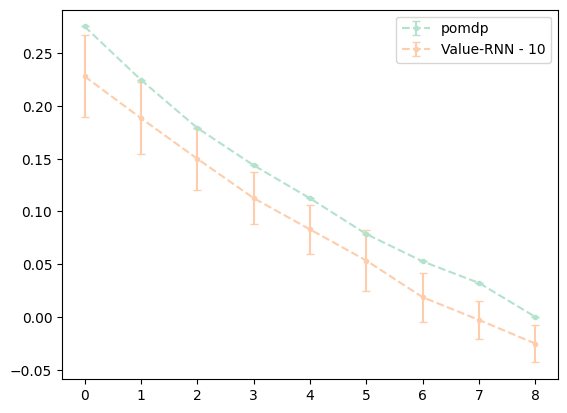

In [2]:
from belief_analyze import multi_value_analyze, calc_mse, compare_rpes_plot
from belief_utils import extract_last_vals, calc_rpe_groups

trial_dict = multi_value_analyze(0.)
print("MSEs: ", calc_mse(trial_dict))
rpegroup_dict = {}

for key, value in trial_dict.items():
    rpegroup_dict[key] = calc_rpe_groups(value)

compare_rpes_plot(extract_last_vals(rpegroup_dict))

In [ ]:
from belief_analyze import fit_weights, add_value_and_rpe, calc_rpe_groups, plot_rpes
from belief_utils import convert_to_mytrial
from belief_pomdp import add_pomdp_states_beliefs
from models.rnn_utils import eval_value_wrapper

eval_dataset = MyStarkweather(n_sequences=2, len_sequences=10_000, omission_probability=0.0, iti_p=1/8, iti_min=10)

trials = add_pomdp_states_beliefs(eval_dataset, 0.1, 1/8, 10)
weights = fit_weights(trials)
trials = add_value_and_rpe(trials, weights, 0.93)

my_trials = convert_to_mytrial(trials)
pomdp_rpe_groups = calc_rpe_groups(my_trials)
plot_rpes(pomdp_rpe_groups)
